## How do we measure the similarity of names in terms of the evolution of their use over time?

This is the question that kickstarted this small toy project. It gave me a nice excuse to take my first steps into the pandas project. We took data from Argentina's public data portal so the results are only applicable there. The ideas could be adapted to any population if the data is available.

### Data loading and preprocessing

Naming by year in Argentina dataset taken from [this website](http://www.datos.gob.ar/dataset/nombres-personas-fisicas). Here we assume the file `historico-nombres.csv` is placed in the same folder as the python script.

In [40]:
import os
import numpy as np
import pandas
pandas.set_option('max_rows', 10)

folder = os.getcwd()
file_name = os.path.join(folder, 'historico-nombres.csv')

df = pandas.read_csv(file_name)
df.columns = ['name', 'amount', 'year'] 
df.head()

,name,amount,year
0,Maria,314,1922
1,Rosa,203,1922
2,Jose,163,1922
3,Maria Luisa,127,1922
4,Carmen,117,1922


We see the dataset is a table with three columns. Each row indicates the number of people named in a certain way in a given year, from 1922 to 2015.

The dataset has some inconsistencies that need fixing. For example, we want to treat "Raúl", "Raul" and " Raul" as the same name.

In [42]:
# Strip tildes and spaces
df.name = df.name.str.strip(' .,|')
df.name = df.name.str.normalize('NFKD')
df.name = df.name.str.encode('ascii', errors='ignore').str.decode('utf-8')
df.name = df.name.str.replace(r"\(.*","")
df.name = df.name.str.lower()

# After processing, we will have repeated entries (the same name appearing in a single year) that we need to sum 
df = df.groupby(['name', 'year']).sum().reset_index()

A fair comparison year to year would use naming probabilities instead of naming amounts. Therefore, we need to divide each value by each year's total. 

In [43]:
total = df.groupby('year').amount.transform('sum')
df['probability'] = 100*df.amount/total
df = df[['name', 'year', 'probability']]    # Here we drop 'amount' column, we keep 'probability'

### Dropping data we don't need

How many different names are there in the list? How are they distributed?

Number of different names:  3061802
(-0.0009260000000000001, 0.0501]    943
(0.0501, 0.1]                       354
(0.1, 0.15]                         216
(0.15, 0.2]                         140
(0.2, 0.25]                         100
Name: probability, dtype: int64


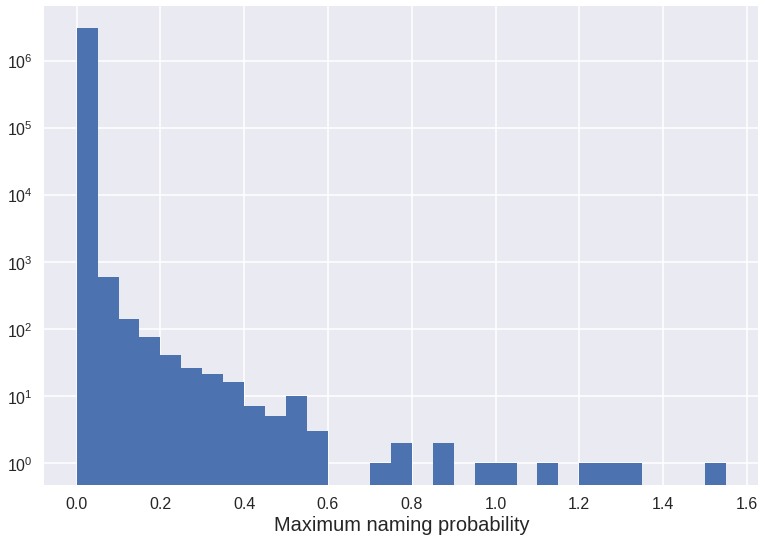

In [93]:
n = df.name.nunique()
print('Number of different names: ', n)

# Histogram
fig, ax = plt.subplots()
max_probabilities = df.groupby('name')['probability'].max()
bins = np.arange(min(max_probabilities), max(max_probabilities) + 0.05, 0.05)    # We bin data in 0.05% increments
max_probabilities.hist(log=True, bins=bins)
ax.set_xlabel('Maximum naming probability', fontsize=20)

print(n - max_probabilities.value_counts(bins=bins).cumsum().iloc[:5])

We see we have over 3 million different names but only less than 1000 reach a probability of 0.05%. The histogram shows there are more than three orders of magnitude between the first and second bin. Since we will only be interested in fairly common names, we will just keep those with a maximum probability of at least 0.05.

In [ ]:
df = df.groupby('name').filter(lambda x: np.any(x.probability > 0.05))

print('Number of different names: ', df.name.nunique())

The features of each name will be each year's naming probability. Therefore, we have to move the years to the columns labels. This way, every single name will be represented as a row. Since this dataset does not include years with naming amount equal to zero, in the new representation missing data will have to be replaced by zeroes. 

In [96]:
df = df.set_index(['name', 'year']).probability.unstack()
df.fillna(0, inplace=True)
df.head()

Next, we smooth the data with a 5 year window because we are not interested in fast changes when comparing name trends. Once smoothed, we keep one data point every 5 years.

In [98]:
def smooth(y, n):
    n = np.min([len(y), n])
    box = np.ones(n)/n
    ySmooth = np.convolve(y, box, mode='same')
    return ySmooth

df = df.apply(lambda x: smooth(x, 5), axis=1)

# Once smoothed, we exclude data on the time edges because the smoothing is not effective there.
pad = 5//2
yrs = (df.columns[-1 - pad] - df.columns[pad])
df = df.iloc[:, list(np.arange(pad, yrs, 5))]

How data looks now.

In [99]:
df.head()

year,1924,1929,1934,1939,1944,1949,1954,1959,1964,1969,1974,1979,1984,1989,1994,1999,2004,2009
name,,,,,,,,,,,,,,,,,,
abril,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061,0.000000,0.000102,0.000130,0.001151,0.011472,0.085924,0.157746,0.093620
adela,0.138682,0.098194,0.083173,0.051787,0.037440,0.028439,0.020482,0.017497,0.016626,0.013102,0.008506,0.007353,0.006418,0.004856,0.002633,0.001098,0.000781,0.001559
adelaida,0.039425,0.036597,0.028950,0.023223,0.018194,0.016922,0.015419,0.011146,0.008885,0.006189,0.004281,0.003339,0.003009,0.002819,0.001571,0.000865,0.000516,0.000187
adelina,0.098266,0.073453,0.049704,0.039264,0.027734,0.022658,0.014906,0.013861,0.008023,0.005570,0.003515,0.003794,0.002722,0.002967,0.001522,0.000835,0.000773,0.000867
adolfo,0.079500,0.076196,0.070493,0.063345,0.053743,0.039679,0.031995,0.029128,0.023658,0.015156,0.010175,0.010474,0.009725,0.006738,0.004276,0.002130,0.002094,0.001971


### Adding gender information

We need to generate a new column with gender information for each name. For this we will evaluate the gender of the first name in each entry against [this database](https://github.com/organisciak/names).

In [100]:
# Keep first word in each name and strip all tildes
df['gender'] = df.index.str.split().str.get(0)

# Generate gender column
# Thanks to https://stackoverflow.com/questions/48993409/assign-values-groupwise-using-the-group-name-as-input
gn = pandas.read_csv(os.path.join(folder, 'us-names-by-gender-state-year.csv'))
gn.name = gn.name.str.lower()
gn = gn.groupby('name').first().reset_index()[['name', 'sex']]
df.gender = df.gender.replace(dict(zip(gn.name, gn.sex)))

### Measuring similarity and visualizing results

We are going to measure the similarity between any two names as the quadratic sum of differences between the values of their features. That is to say, their probability arrays over time.

In [ ]:
def timeSimilarity(df, name):

    # Get name's sex
    gen = df.loc[name]['gender']

    # Only keep names with the same sex and exclude the gender column
    df = df[df.gender == gen].iloc[:, :-1]

    use_trend = df.loc[name].values
    n = len(df.index)
    result = pandas.DataFrame(
        {'name': [''] * n, 'similarity': [None] * n})

    result.name = df.index
    for i in np.arange(n):
        diff = df.iloc[i, :].values - use_trend
        result.similarity[result.name == df.index[i]] = np.sum(diff**2)
    return result

Let's take a look at the results for the name "virginia" as an example. We can list the most and the least similar names.

In [121]:
results = timeSimilarity(df, 'virginia').sort_values(by='similarity')
print(results)

                 name  similarity
505          virginia           0
292       maria julia  0.00116193
74            cecilia  0.00150801
202             laura  0.00161193
325            marina  0.00205274
..                ...         ...
452              rosa     1.09346
264  maria del carmen     1.64696
238             maria     2.14243
260    maria cristina     2.91974
31          ana maria     4.44416

[515 rows x 2 columns]


Let's plot the naming trend over time for "virginia" and a few others. We see how closely "maria julia" fits "virginia" compared to "gabriela soledad" and "esther".

                 name  similarity
505          virginia           0
292       maria julia  0.00116193
155  gabriela soledad   0.0157149
133            esther   0.0341416


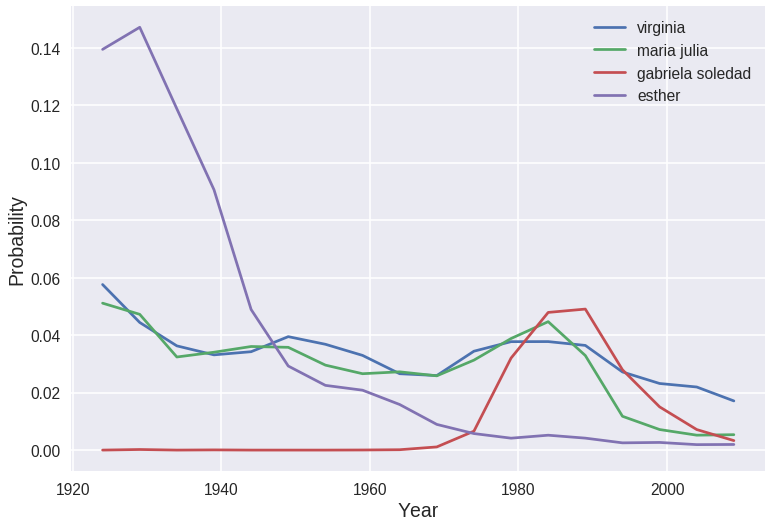

In [130]:
print(results.iloc[[0, 1, int(0.4*len(results)), int(0.8*len(results))]])

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
fig = plt.figure(dpi=70, facecolor='w', edgecolor='k')
ax1 = df.loc['virginia'][:-1].plot()
df.loc['maria julia'][:-1].plot()
df.loc['gabriela soledad'][:-1].plot()
df.loc['esther'][:-1].plot()
ax1.legend()
ax1.set_ylabel('Probability', fontsize=20)
ax1.set_xlabel('Year', fontsize=20)
ax1.grid()

We would like to visualize the whole dataset. We apply principal component analysis to reduce the amount of features to 2, so that we can visualize them in a 2d plot. Following [this guide](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60).

In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Separating out the features (we drop the gender)
x = df[df.gender == 'F'].iloc[:, :-1].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
pca_x = pca.fit_transform(x)
pca_df = pandas.DataFrame(data=pca_x, columns = ['principal component 1', 'principal component 2'])
pca_df['name'] = df[df.gender == 'F'].index

pca_df.head()

,principal component 1,principal component 2,name
0,-1.820200,1.104530,abril
1,0.211481,-1.554167,adela
2,-0.920068,-1.154190,adelaida
3,-0.421686,-1.447306,adelina
4,-0.134817,-0.263345,adriana


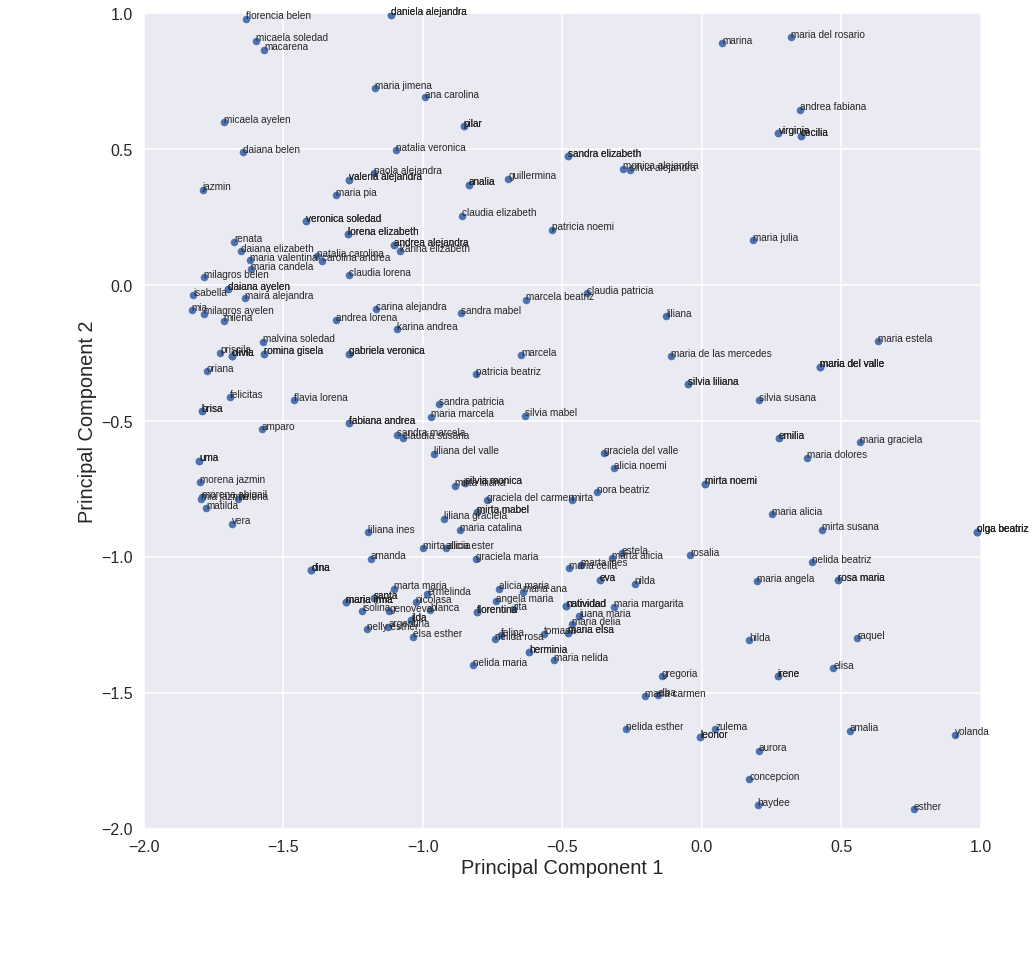

In [138]:
sample = pca_df.sample(frac=0.5, replace=True) # We keep half of the data so that the graph is less messy

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1, 1, 1) 
ax.scatter(sample['principal component 1'], sample['principal component 2'], s=50)
for index, row in sample.iterrows():
    ax.annotate(row['name'], (row['principal component 1'], row['principal component 2']))

ax.set_xlabel('Principal Component 1', fontsize=20)
ax.set_ylabel('Principal Component 2', fontsize=20)
ax.set_xlim(-2, 1)
ax.set_ylim(-2, 1)
ax.grid()

Cool!

## Concluding remarks

This was a fun idea! It could be extended to add more features and further expand the idea of similarity between names. Some of these features could be

+ vowel/consonant ratio
+ length
+ whether it is a single word name or not

For the moment, the analysis presented here fullfills my pandas practice needs. Would you have done it differently? Is it possible to optimize some part of it? Please let me know in the comments!